# Расчет и прогнозирования объемов данных DWH

In [25]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sqlalchemy import create_engine
from statsmodels.graphics import tsaplots
import warnings
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from IPython.display import Markdown as md

plt.rcParams["figure.figsize"] = (12, 8)

SQL_STATS = "select rec_id, rec_date, db_name, schema_name || '.' || object_name as object_name, object_size, row_count from stats"
MEASURE = 'object_size'
DIVIDER = 1024 * 1024 * 1024 # bytes -> GB
SLACK = 0.1
BACKUP_SIZE = 69 * DIVIDER
DB_HOST = 'cn-msk-dwh-02'
LOGIN = 'SECRET'
PSW = 'SECRET!'

conn = create_engine(f'postgresql://{LOGIN}:{PSW}@{DB_HOST}:5432/stage')

Для сбора статистики разработан DAG ctrl-stats, формирующий временные ряды количеств записей и объемов для всех таблиц DWH, а также объемов данных баз данных целиком и дискового пространства.
Набранная статистика:

In [26]:
df_stats = pd.read_sql(SQL_STATS, conn, index_col='rec_id', parse_dates=['rec_date'])
print(f'Дата начала сбора статистики: {min(df_stats.rec_date)}')
print(f'Актуальность: {max(df_stats.rec_date)}')
print(f'Количество записей {df_stats.shape[0]}')

Дата начала сбора статистики: 2021-10-03 00:00:00
Актуальность: 2021-10-24 00:00:00
Количество записей 4805



В набранной статистике могут быть выделены три временных ряда:

<ul>
<li>Данные количества записей и объемов каждой таблицы DWH</li>
<li>Данные объема данных в каждой БД DWH</li>
<li>Данные объема доступного дискового пространства</li>
</ul>

In [27]:
# Выделяем временные ряды по таблицам, по БД, по дисковому пространству
# Ряд по ДП приводим к тем же единицам что и остальные (он в килобайтах)
ts_tbl = df_stats[ ~df_stats['object_name'].isna() ].copy()
ts_db = df_stats[ df_stats['object_name'].isna() & (df_stats['db_name'] != 'disk') ].copy()
ts_disk = df_stats[ df_stats['object_name'].isna() & (df_stats['db_name'] == 'disk') ].copy()
ts_disk['object_size'] = ts_disk['object_size'] * 1024

In [28]:
print(f'Характеристики временного ряда по таблицам:\n{ts_tbl.describe()}')
print(f'\nХарактеристики временного ряда по БД:\n{ts_db.describe()}')
print(f'\nХарактеристики временного ряда по дискам:\n{ts_disk.describe()}')

Характеристики временного ряда по таблицам:
        object_size     row_count
count  4.685000e+03  4.685000e+03
mean   3.173575e+09  1.223261e+07
std    1.414879e+10  5.312849e+07
min    8.192000e+03  0.000000e+00
25%    4.096000e+04  1.100000e+01
50%    1.228800e+05  3.560000e+02
75%    7.084605e+08  4.948764e+06
max    1.356334e+11  4.672943e+08

Характеристики временного ряда по БД:
        object_size  row_count
count  1.010000e+02        0.0
mean   1.482553e+11        NaN
std    1.560411e+11        NaN
min    1.050775e+07        NaN
25%    2.982828e+10        NaN
50%    3.096189e+10        NaN
75%    3.065654e+11        NaN
max    3.783724e+11        NaN

Характеристики временного ряда по дискам:
        object_size  row_count
count  1.900000e+01        0.0
mean   9.861993e+11        NaN
std    0.000000e+00        NaN
min    9.861993e+11        NaN
25%    9.861993e+11        NaN
50%    9.861993e+11        NaN
75%    9.861993e+11        NaN
max    9.861993e+11        NaN



Анализируем временной ряд по таблицам. Проверим полноту данных (что данные есть для всех таблиц за все дни).

In [29]:
# Анализ временного ряда по таблицам
ts_tbl['object_name'] = ts_tbl['db_name'] + '.' + ts_tbl['object_name']
ts_tbl.drop(columns=['db_name'], inplace=True)
ts_tbl.groupby(by=['rec_date']).count().reset_index().head(10)

,rec_date,object_name,object_size,row_count
0,2021-10-03,149,149,149
1,2021-10-04,149,149,149
2,2021-10-05,149,149,149
3,2021-10-06,216,216,216
4,2021-10-07,216,216,216
5,2021-10-08,216,216,216
6,2021-10-09,217,217,217
7,2021-10-10,217,217,217
8,2021-10-11,217,217,217
9,2021-10-12,220,220,220


<b>Вывод</b>: данные до 06.10 неполные и могут быть отброшены.

In [30]:
# Отбрасываем данные до 06.10
MIN_DATE = pd.Timestamp('2021-10-06')
ts_tbl2 = ts_tbl[ ts_tbl.rec_date >= MIN_DATE]

Посмотрим матрицу корреляции между переменными ```object_size``` (размер таблицы в байтах) и ```row_count``` (количество записей).

In [31]:
# Строим матрицу корреляции между переменными
corr = ts_tbl2.corr()
corr.style.background_gradient(cmap='coolwarm')

,object_size,row_count
object_size,1.000000,0.947402
row_count,0.947402,1.000000


<b>Вывод</b>: наблюдается сильная корреляция между переменными, так что можно использовать только одну из них. 

Для дальнейшего анализа будет использоваться переменная ```object_size```.

In [32]:
# Поскольку корреляция высокая, отбрасываем row_count
ts_tbl3 = ts_tbl2.drop(columns=['row_count'])

# Считаем объем всех баз на каждый день
ts_tbl3['db_name'] = ts_tbl3['object_name'].map(lambda x: x.split('.')[0])
ts_tbl3_sum = ts_tbl3.groupby(by=['rec_date', 'db_name']).sum().reset_index()

Проведем визуальный анализ временного ряда по БД.

Text(0, 0.5, 'Размер (GB)')

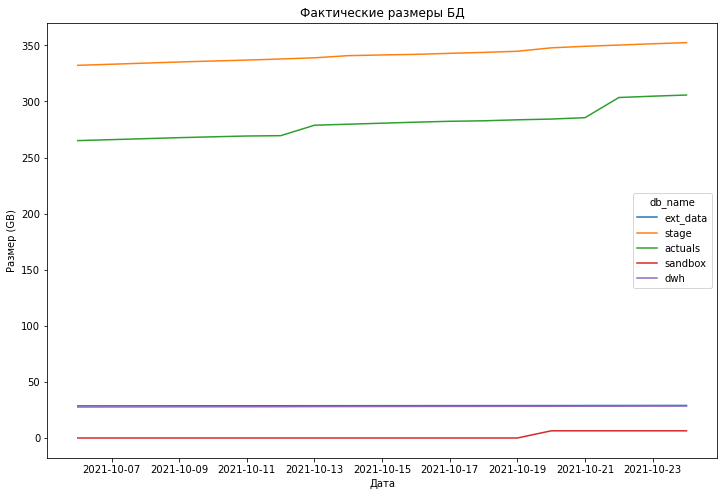

In [33]:
# Отбрасываем незначащие колонки и данные до 06.10
ts_db2 = ts_db[ ts_db['rec_date'] >= MIN_DATE ] \
    .drop(columns=['object_name', 'row_count']) \
    .reset_index()

# Отображение данных
ts_db3 = ts_db2.copy()
ts_db3['object_size'] = ts_db3['object_size'] / DIVIDER
ax = sns.lineplot(data=ts_db3, x='rec_date', y='object_size', hue='db_name')
ax.set_title('Фактические размеры БД')
ax.set_xlabel('Дата')
ax.set_ylabel('Размер (GB)')

Из приведенной диаграммы видно что ряд монотонно увеличивается для каждой категории ```db_name``` - что в общем-то и ожидалось.

Сравним значения объема БД, полученные из рядов по БД и по таблицам.

In [44]:
# Сравниваем размеры БД с размерами, полученными на данных временного ряда по таблицам
df = ts_db2 \
    .merge(ts_tbl3.groupby(by=['rec_date', 'db_name']).sum(), on=['rec_date', 'db_name'])
df['diff'] = df.object_size_x - df.object_size_y
print(df.sort_values(by='diff', ascending=False)[['rec_date', 'db_name', 'object_size_x', 'object_size_y', 'diff']].head(10))

     rec_date db_name  object_size_x  object_size_y        diff
85 2021-10-24     dwh    30601672167    25838616576  4763055591
80 2021-10-23     dwh    30565004775    25801949184  4763055591
75 2021-10-22     dwh    30492628455    25730465792  4762162663
60 2021-10-19     dwh    30327772647    25565609984  4762162663
70 2021-10-21     dwh    30447523303    25685360640  4762162663
65 2021-10-20     dwh    30356977127    25594814464  4762162663
55 2021-10-18     dwh    30274172391    25512017920  4762154471
50 2021-10-17     dwh    30247589351    25485443072  4762146279
45 2021-10-16     dwh    30212183527    25450037248  4762146279
40 2021-10-15     dwh    30151316967    25389170688  4762146279


<b>Вывод</b>: наблюдаются существенные расхождения в значениях целевой переменной, полученных из разных рядов, поэтому их совместное использование нецелесообразно. Для дальнейшего анализа будет использован только ряд по БД.

Посчитаем суммарный объем всех БД на каждую дату:

In [35]:
# Создаем ряд суммарного объема БД
ts_all = ts_db2.groupby('rec_date', as_index=False).sum()[['rec_date', 'object_size']]
x = ts_all.rec_date
y = ts_all.object_size
print(f'Суммарный объем БД:\n{ts_all.head(10)}')

Суммарный объем БД:
    rec_date   object_size
0 2021-10-06  701714394499
1 2021-10-07  703768702339
2 2021-10-08  705880984963
3 2021-10-09  707990179203
4 2021-10-10  709808795011
5 2021-10-11  711482502531
6 2021-10-12  712954318211
7 2021-10-13  724187540867
8 2021-10-14  727324339587
9 2021-10-15  729030430083


Для устойчивой работы алгоритмов анализа необходимо соблюдение условий стационарности. Определим, соблюдается ли это условие для временного ряда суммарного объема БД. В случае, если оное условие не соблюдается, определем количество дифференциаторов для приведения ряда к стационарному.

In [36]:
# Проверяем стационарность ряда
print(f'Соблюдение условия стационарности временного ряда: {not pm.arima.KPSSTest().should_diff(y)[1]}')
print(f'Количество дифференциаторов для обеспечения стационарности: {pm.arima.ndiffs(y)}')

Соблюдение условия стационарности временного ряда: False
Количество дифференциаторов для обеспечения стационарности: 1


Исходя из того, что целевая переменная монотонно увеличивается для каждой из категории, предполагаем отсутствие ярко выраженной сезонности. Поэтому для прогнозирования может быть использована модель анализа временных рядов ARIMA (AutoRegressive Integrated Moving Average). 

Подбираем параметры модели:

In [37]:
# Строим модель ARIMA
y_train, y_test = train_test_split(y, train_size=0.8)
x_train, x_test = x[:y_train.shape[0]], x[y_train.shape[0]:]

with warnings.catch_warnings():
    warnings.filterwarnings('ignore', category=FutureWarning)
    model = pm.auto_arima(y_train, seasonal=False, suppress_warnings=True)
model

ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True)

Построенная модель использует параметры ```p=0``` и ```q=0```, то есть практически линейна. Это говорит о недостаточности объема накопленной статистики. Возможно, по мере накопления данных, ситуация поменяется.

Построим прогноз изменения объема данных на 60 дней и отобразим динамику визуально.
К актуальному и предсказанным объемам будет добавлен объем backup в размере 69 GB (состояние на 25.10.2021). Исходя из прогноза и временного ряда по диска, определим дату возможного исчерпания дискового пространства.

In [38]:
# Предсказание на 60 дней
FCAST_WINDOW = 60
x_pred = pd.Series(pd.date_range(min(x_test), periods=FCAST_WINDOW, freq='D'))
y_pred = model.predict(FCAST_WINDOW)

In [39]:
# Добавляем бэкап или слак
# y2 = y * (1 + SLACK )
# y_train2 = y_train * (1 + SLACK)
# y_pred2 = y_pred * (1 + SLACK)
y2 = y + BACKUP_SIZE
y_train2 = y_train + BACKUP_SIZE
y_pred2 = y_pred + BACKUP_SIZE

In [40]:
# Формируем ряд для диска
x_disk = x_train
x_disk = x_disk.append(x_pred)
x_disk = x_disk.reset_index(drop=True)
y_disk = ts_disk.object_size
y_disk = y_disk.append(pd.Series([y_disk.iloc[-1] for y in range(len(x_disk) - len(y_disk))]))
y_disk = y_disk.reset_index(drop=True)

In [41]:
# Определяем дату исчерпания объема диска
dt_full = None
for dp, vp in zip(x_pred, y_pred2):
    vd = y_disk[ x_disk[ x_disk == dp].index ]
    if vd.to_numpy()[0] < vp:
        dt_full = dp
        break

if dt_full:
    print(f'Ожидаемая дата исчерпания ДП: {dt_full.strftime("%Y-%m-%d")}')
else:
    print('На заданном горизонте ДП хватит')

Ожидаемая дата исчерпания ДП: 2021-12-11


In [42]:
# Переводим в гигабайты
y3 = y2 / DIVIDER
y_train3 = y_train2 / DIVIDER
y_pred3 = y_pred2 / DIVIDER
y_disk3 = y_disk / DIVIDER

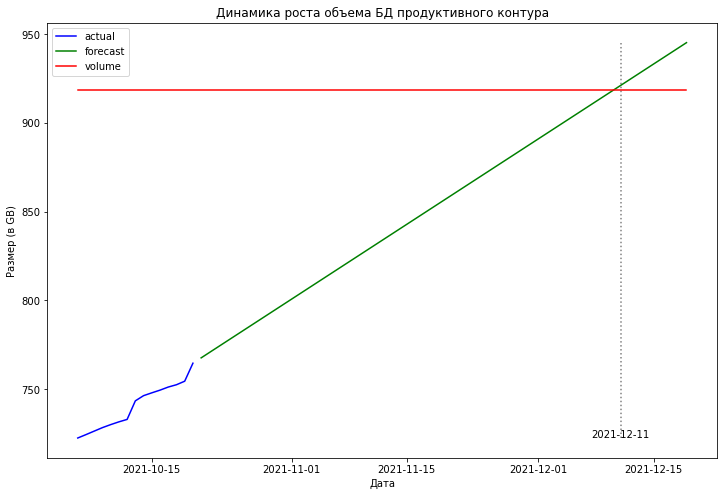

In [43]:
# Вывод
p = plt.plot(x_train, y_train3, c='blue')
p[0].set_label('actual')
p = plt.plot(x_pred, y_pred3, c='green')
p[0].set_label('forecast')
p = plt.plot(x_disk, y_disk3, c='red')
p[0].set_label('volume')
if dt_full:
    plt.vlines(dt_full, ymin=min(y3), ymax=max(y_pred3), colors='gray', linestyles='dotted')
    plt.text(x=dt_full, y=min(y3), s=dt_full.strftime("%Y-%m-%d"), horizontalalignment='center')
plt.legend()
plt.title('Динамика роста объема БД продуктивного контура')
plt.xlabel('Дата')
plt.ylabel('Размер (в GB)')
plt.show()

<b>Вывод</b>: исходя из текущей тенденции роста объема базы, возможно скорое исчерпание дискового пространства. Необходимо принять меры по его расширению во избежание сбоя процессов загрузки.